In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import models, layers, regularizers, callbacks


In [2]:
# Load dataset
df = pd.read_csv("merged_weather_pm25.csv")
df = df.drop(columns=["name"])  # drop unhelpful cols
df.dropna(inplace=True)

# Sort by date to preserve temporal order
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.drop(columns=['date'], inplace=True)

# Normalize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Separate features and target
target_index = df.columns.get_loc("pm25")

X_all = []
y_all = []
sequence_length = 7  # look back 7 days

for i in range(sequence_length, len(df)):
    X_all.append(scaled_data[i-sequence_length:i, :])
    y_all.append(scaled_data[i, target_index])  # predict pm25 of current day

X_all = np.array(X_all)
y_all = np.array(y_all)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [4]:
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [5]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
9/9 [==============================] - 6s 104ms/step - loss: 0.8038 - mae: 0.6359 - val_loss: 0.3491 - val_mae: 0.3581
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 0.4993 - mae: 0.4716 - val_loss: 0.3223 - val_mae: 0.3777
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.4609 - mae: 0.4561 - val_loss: 0.2946 - val_mae: 0.3217
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.4780 - mae: 0.4487 - val_loss: 0.3089 - val_mae: 0.3273
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.4196 - mae: 0.4134 - val_loss: 0.2905 - val_mae: 0.3139
Epoch 6/100
9/9 [==============================] - 0s 17ms/step - loss: 0.4140 - mae: 0.4279 - val_loss: 0.2759 - val_mae: 0.3021
Epoch 7/100
9/9 [==============================] - 0s 17ms/step - loss: 0.4114 - mae: 0.4261 - val_loss: 0.2711 - val_mae: 0.3030
Epoch 8/100
9/9 [==============================] - 0s 15ms/step - loss: 0.4111 - mae: 0.4

In [6]:
y_pred = model.predict(X_test).flatten()
y_test_inv = y_test * scaler.scale_[target_index] + scaler.mean_[target_index]
y_pred_inv = y_pred * scaler.scale_[target_index] + scaler.mean_[target_index]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(f"🧠 LSTM MAE: {mae:.2f}")
print(f"🧠 LSTM MSE: {mse:.2f}")


3/3 [==============================] - 1s 6ms/step
🧠 LSTM MAE: 27.01
🧠 LSTM MSE: 1158.08


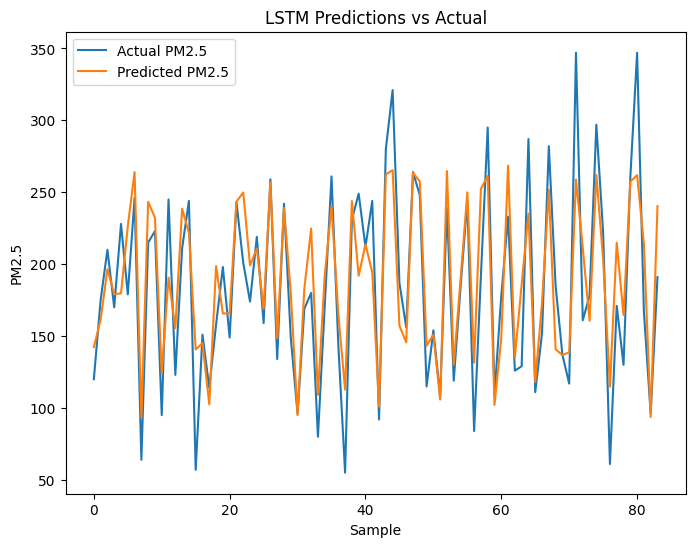

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(y_test_inv, label='Actual PM2.5')
plt.plot(y_pred_inv, label='Predicted PM2.5')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('PM2.5')
plt.show()
